# Intragene diversity 
  
**Author**: Katarina Braun 

## Overview
- The purpose of this script is to generate genewise nucleotide diversity (π) using the SNPGenie script and then to gnerate plots to visualize and compare genewise πS (synonymous diversity) and πN (nonsynonymous diversity). 

## Dependencies 
- pandas
- numpy
- matplotlib
- glob
- os
- functools
- pandas
- itertools
- glob
- os
- sklearn 
- pysam
- random 
- seaborn 

First, this notebook will go over syntax to run (SNPGenie)[https://github.com/chasewnelson/SNPGenie]. SNPGenie is a collection of Perl scripts for estimating πN/πS, dN/dS, and gene diversity from next-generation sequencing (NGS) single-nucleotide polymorphism (SNP) variant data. 

WITHIN-POOL ANALYSIS. Use snpgenie.pl, the original SNPGenie. Analyzes within-sample πN/πS from pooled NGS SNP data. SNP reports (VCF) must each correspond to a single population/pool, with variants called relative to one reference sequence (one sequence in one FASTA file).

Here's the syntax for running SNPGenie that I am using: 

```bash
perl snpgenie.pl --vcfformat=4 --snpreport=path/to/SNPREPORT.vcf --fastafile=path/to/ref.fasta --gtffile=/path/to/GTF.gtf

```

SNPGenie will not take in a reference and GTF divided into genes, but we used a reference that is divided into gene segments to generate original SNV calls. 

- **ORF1a**: +265    
- **ORF1b**: +13,468  
- **S**: +21,559  
- **ORF3a**: +25,389  
- **E**: +26,241  
- **M**: +26,519  
- **ORF6**: +27,189  
- **ORF7a**: +27,390  
- **ORF8**: +27,890  
- **N**: +28,780  
- **ORF10**: +29,554

Then, this notebook will take raw diveristy (π) data and generate plots to visualize and compare genewise πS (synonymous diveristy) and πN(nonsynonymous diversity). 
- will plot π, pulled from `population_summary.txt` files -- fifth column 
- plot each gene within each sample

## Input: 

- `SNPGenie_ouput/sample/product_results.txt`



## Output:  

- Nucleotide diversity figure.


### import modules and dependencies

In [8]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import ListedColormap

# Load raw VCFs (generated by `Sniffles`) into dataframes and update numbering schemes

SNPGenie will not take in a reference and GTF divided into genes, but we used a reference that is divided into gene segments to generate original SNV calls. So, I am just going to go into these original VCFs generated by `Sniffles` and edit the `POS` column to align with the whole-genome REF and GTF file (otherwise the only diversity that will be calculated will be in ORF1a. 

- **ORF1a**: +265    
- **ORF1b**: +13,468  
- **S**: +21,559  
- **ORF3a**: +25,389  
- **E**: +26,241  
- **M**: +26,519  
- **ORF6**: +27,189  
- **ORF7a**: +27,390  
- **ORF8**: +27,890  
- **N**: +28,780  
- **ORF10**: +29,554  

In [46]:
# load and edit primary_NP_swab to align the whole-genome and individual-gene numbering schemes

primary_NP_swab = pd.read_csv('VCFs_raw/primary_NP_swab.vcf', sep='\t', skiprows=26)
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF1a'), 'POS'] = primary_NP_swab['POS']+265
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF1b'), 'POS'] = primary_NP_swab['POS']+13767
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_S'), 'POS'] = primary_NP_swab['POS']+21559
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF3a'), 'POS'] = primary_NP_swab['POS']+25389
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_E'), 'POS'] = primary_NP_swab['POS']+26241
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_M'), 'POS'] = primary_NP_swab['POS']+26519
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF6'), 'POS'] = primary_NP_swab['POS']+27189
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF7a'), 'POS'] = primary_NP_swab['POS']+27390
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF8'), 'POS'] = primary_NP_swab['POS']+27890
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_N'), 'POS'] = primary_NP_swab['POS']+28780
primary_NP_swab.loc[primary_NP_swab['#CHROM'].str.contains('SARS_CoV_2_ORF10'), 'POS'] = primary_NP_swab['POS']+29554

primary_NP_swab.to_csv('VCFs_adjusted_numbering/primary_NP_swab.vcf', sep='\t', index=False)

#write in the standard VCF headers 
f = open('VCFs_adjusted_numbering/primary_NP_swab.vcf','r+')
lines = f.readlines() # read old content
f.seek(0) # go back to the beginning of the file
f.write('##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="All filters passed">\n##source=VarScan2\n##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">\n##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">\n##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">\n##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">\n##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">\n##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">\n##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">\n##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality Read Depth of bases with Phred score >= 30">\n##FORMAT=<ID=RD,Number=1,Type=Integer,Description="Depth of reference-supporting bases (reads1)">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Depth of variant-supporting bases (reads2)">\n##FORMAT=<ID=FREQ,Number=1,Type=String,Description="Variant allele frequency">\n##FORMAT=<ID=PVAL,Number=1,Type=String,Description="P-value from Fisher\'s Exact Test">\n##FORMAT=<ID=RBQ,Number=1,Type=Integer,Description="Average quality of reference-supporting bases (qual1)">\n##FORMAT=<ID=ABQ,Number=1,Type=Integer,Description="Average quality of variant-supporting bases (qual2)">\n##FORMAT=<ID=RDF,Number=1,Type=Integer,Description="Depth of reference-supporting bases on forward strand (reads1plus)">\n##FORMAT=<ID=RDR,Number=1,Type=Integer,Description="Depth of reference-supporting bases on reverse strand (reads1minus)">\n##FORMAT=<ID=ADF,Number=1,Type=Integer,Description="Depth of variant-supporting bases on forward strand (reads2plus)">\n##FORMAT=<ID=ADR,Number=1,Type=Integer,Description="Depth of variant-supporting bases on reverse strand (reads2minus)">\n##bcftools_normVersion=1.9+htslib-1.9\n##bcftools_normCommand=norm -c sw -m - -f /ref/primary_NP_swab.fasta -o primary_NP_swab.vcf primary_NP_swab_temp.vcf; Date=Tue Apr  7 00:23:21 2020\n')
for line in lines: # write old content after new
    f.write(line)
f.close()

#

In [43]:
# load and edit p1_vero76 to align the whole-genome and individual-gene numbering schemes

p1_vero76 = pd.read_csv('VCFs_raw/p1_vero76.vcf', sep='\t', skiprows=26)
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF1a'), 'POS'] = p1_vero76['POS']+265
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF1b'), 'POS'] = p1_vero76['POS']+13767
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_S'), 'POS'] = p1_vero76['POS']+21559
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF3a'), 'POS'] = p1_vero76['POS']+25389
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_E'), 'POS'] = p1_vero76['POS']+26241
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_M'), 'POS'] = p1_vero76['POS']+26519
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF6'), 'POS'] = p1_vero76['POS']+27189
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF7a'), 'POS'] = p1_vero76['POS']+27390
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF8'), 'POS'] = p1_vero76['POS']+27890
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_N'), 'POS'] = p1_vero76['POS']+28780
p1_vero76.loc[p1_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF10'), 'POS'] = p1_vero76['POS']+29554

p1_vero76.to_csv('VCFs_adjusted_numbering/p1_vero76.vcf', sep='\t', index=False)

#write in the standard VCF headers 
f = open('VCFs_adjusted_numbering/p1_vero76.vcf','r+')
lines = f.readlines() # read old content
f.seek(0) # go back to the beginning of the file
f.write('##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="All filters passed">\n##source=VarScan2\n##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">\n##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">\n##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">\n##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">\n##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">\n##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">\n##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">\n##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality Read Depth of bases with Phred score >= 30">\n##FORMAT=<ID=RD,Number=1,Type=Integer,Description="Depth of reference-supporting bases (reads1)">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Depth of variant-supporting bases (reads2)">\n##FORMAT=<ID=FREQ,Number=1,Type=String,Description="Variant allele frequency">\n##FORMAT=<ID=PVAL,Number=1,Type=String,Description="P-value from Fisher\'s Exact Test">\n##FORMAT=<ID=RBQ,Number=1,Type=Integer,Description="Average quality of reference-supporting bases (qual1)">\n##FORMAT=<ID=ABQ,Number=1,Type=Integer,Description="Average quality of variant-supporting bases (qual2)">\n##FORMAT=<ID=RDF,Number=1,Type=Integer,Description="Depth of reference-supporting bases on forward strand (reads1plus)">\n##FORMAT=<ID=RDR,Number=1,Type=Integer,Description="Depth of reference-supporting bases on reverse strand (reads1minus)">\n##FORMAT=<ID=ADF,Number=1,Type=Integer,Description="Depth of variant-supporting bases on forward strand (reads2plus)">\n##FORMAT=<ID=ADR,Number=1,Type=Integer,Description="Depth of variant-supporting bases on reverse strand (reads2minus)">\n##bcftools_normVersion=1.9+htslib-1.9\n##bcftools_normCommand=norm -c sw -m - -f /ref/p1_vero76.fasta -o p1_vero76.vcf p1_vero76_temp.vcf; Date=Tue Apr  7 00:23:21 2020\n')
for line in lines: # write old content after new
    f.write(line)
f.close()

#

In [44]:
# load and edit p1_veroE6 to align the whole-genome and individual-gene numbering schemes

p1_veroE6 = pd.read_csv('VCFs_raw/p1_veroE6.vcf', sep='\t', skiprows=26)
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF1a'), 'POS'] = p1_veroE6['POS']+265
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF1b'), 'POS'] = p1_veroE6['POS']+13767
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_S'), 'POS'] = p1_veroE6['POS']+21559
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF3a'), 'POS'] = p1_veroE6['POS']+25389
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_E'), 'POS'] = p1_veroE6['POS']+26241
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_M'), 'POS'] = p1_veroE6['POS']+26519
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF6'), 'POS'] = p1_veroE6['POS']+27189
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF7a'), 'POS'] = p1_veroE6['POS']+27390
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF8'), 'POS'] = p1_veroE6['POS']+27890
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_N'), 'POS'] = p1_veroE6['POS']+28780
p1_veroE6.loc[p1_veroE6['#CHROM'].str.contains('SARS_CoV_2_ORF10'), 'POS'] = p1_veroE6['POS']+29554

p1_veroE6.to_csv('VCFs_adjusted_numbering/p1_veroE6.vcf', sep='\t', index=False)

#write in the standard VCF headers 
f = open('VCFs_adjusted_numbering/p1_veroE6.vcf','r+')
lines = f.readlines() # read old content
f.seek(0) # go back to the beginning of the file
f.write('##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="All filters passed">\n##source=VarScan2\n##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">\n##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">\n##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">\n##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">\n##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">\n##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">\n##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">\n##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality Read Depth of bases with Phred score >= 30">\n##FORMAT=<ID=RD,Number=1,Type=Integer,Description="Depth of reference-supporting bases (reads1)">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Depth of variant-supporting bases (reads2)">\n##FORMAT=<ID=FREQ,Number=1,Type=String,Description="Variant allele frequency">\n##FORMAT=<ID=PVAL,Number=1,Type=String,Description="P-value from Fisher\'s Exact Test">\n##FORMAT=<ID=RBQ,Number=1,Type=Integer,Description="Average quality of reference-supporting bases (qual1)">\n##FORMAT=<ID=ABQ,Number=1,Type=Integer,Description="Average quality of variant-supporting bases (qual2)">\n##FORMAT=<ID=RDF,Number=1,Type=Integer,Description="Depth of reference-supporting bases on forward strand (reads1plus)">\n##FORMAT=<ID=RDR,Number=1,Type=Integer,Description="Depth of reference-supporting bases on reverse strand (reads1minus)">\n##FORMAT=<ID=ADF,Number=1,Type=Integer,Description="Depth of variant-supporting bases on forward strand (reads2plus)">\n##FORMAT=<ID=ADR,Number=1,Type=Integer,Description="Depth of variant-supporting bases on reverse strand (reads2minus)">\n##bcftools_normVersion=1.9+htslib-1.9\n##bcftools_normCommand=norm -c sw -m - -f /ref/p1_veroE6.fasta -o p1_veroE6.vcf p1_veroE6_temp.vcf; Date=Tue Apr  7 00:23:21 2020\n')
for line in lines: # write old content after new
    f.write(line)
f.close()

#

In [45]:
# load and edit p1_veroSTAT1KO to align the whole-genome and individual-gene numbering schemes

p1_veroSTAT1KO = pd.read_csv('VCFs_raw/p1_veroSTAT1KO.vcf', sep='\t', skiprows=26)
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF1a'), 'POS'] = p1_veroSTAT1KO['POS']+265
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF1b'), 'POS'] = p1_veroSTAT1KO['POS']+13767
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_S'), 'POS'] = p1_veroSTAT1KO['POS']+21559
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF3a'), 'POS'] = p1_veroSTAT1KO['POS']+25389
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_E'), 'POS'] = p1_veroSTAT1KO['POS']+26241
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_M'), 'POS'] = p1_veroSTAT1KO['POS']+26519
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF6'), 'POS'] = p1_veroSTAT1KO['POS']+27189
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF7a'), 'POS'] = p1_veroSTAT1KO['POS']+27390
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF8'), 'POS'] = p1_veroSTAT1KO['POS']+27890
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_N'), 'POS'] = p1_veroSTAT1KO['POS']+28780
p1_veroSTAT1KO.loc[p1_veroSTAT1KO['#CHROM'].str.contains('SARS_CoV_2_ORF10'), 'POS'] = p1_veroSTAT1KO['POS']+29554

p1_veroSTAT1KO.to_csv('VCFs_adjusted_numbering/p1_veroSTAT1KO.vcf', sep='\t', index=False)

#write in the standard VCF headers 
f = open('VCFs_adjusted_numbering/p1_veroSTAT1KO.vcf','r+')
lines = f.readlines() # read old content
f.seek(0) # go back to the beginning of the file
f.write('##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="All filters passed">\n##source=VarScan2\n##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">\n##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">\n##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">\n##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">\n##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">\n##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">\n##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">\n##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality Read Depth of bases with Phred score >= 30">\n##FORMAT=<ID=RD,Number=1,Type=Integer,Description="Depth of reference-supporting bases (reads1)">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Depth of variant-supporting bases (reads2)">\n##FORMAT=<ID=FREQ,Number=1,Type=String,Description="Variant allele frequency">\n##FORMAT=<ID=PVAL,Number=1,Type=String,Description="P-value from Fisher\'s Exact Test">\n##FORMAT=<ID=RBQ,Number=1,Type=Integer,Description="Average quality of reference-supporting bases (qual1)">\n##FORMAT=<ID=ABQ,Number=1,Type=Integer,Description="Average quality of variant-supporting bases (qual2)">\n##FORMAT=<ID=RDF,Number=1,Type=Integer,Description="Depth of reference-supporting bases on forward strand (reads1plus)">\n##FORMAT=<ID=RDR,Number=1,Type=Integer,Description="Depth of reference-supporting bases on reverse strand (reads1minus)">\n##FORMAT=<ID=ADF,Number=1,Type=Integer,Description="Depth of variant-supporting bases on forward strand (reads2plus)">\n##FORMAT=<ID=ADR,Number=1,Type=Integer,Description="Depth of variant-supporting bases on reverse strand (reads2minus)">\n##bcftools_normVersion=1.9+htslib-1.9\n##bcftools_normCommand=norm -c sw -m - -f /ref/p1_veroSTAT1KO.fasta -o p1_veroSTAT1KO.vcf p1_veroSTAT1KO_temp.vcf; Date=Tue Apr  7 00:23:21 2020\n')
for line in lines: # write old content after new
    f.write(line)
f.close()

#

In [47]:
# load and edit p2a_vero76 to align the whole-genome and individual-gene numbering schemes

p2a_vero76 = pd.read_csv('VCFs_raw/p2a_vero76.vcf', sep='\t', skiprows=26)
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF1a'), 'POS'] = p2a_vero76['POS']+265
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF1b'), 'POS'] = p2a_vero76['POS']+13767
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_S'), 'POS'] = p2a_vero76['POS']+21559
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF3a'), 'POS'] = p2a_vero76['POS']+25389
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_E'), 'POS'] = p2a_vero76['POS']+26241
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_M'), 'POS'] = p2a_vero76['POS']+26519
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF6'), 'POS'] = p2a_vero76['POS']+27189
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF7a'), 'POS'] = p2a_vero76['POS']+27390
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF8'), 'POS'] = p2a_vero76['POS']+27890
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_N'), 'POS'] = p2a_vero76['POS']+28780
p2a_vero76.loc[p2a_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF10'), 'POS'] = p2a_vero76['POS']+29554

p2a_vero76.to_csv('VCFs_adjusted_numbering/p2a_vero76.vcf', sep='\t', index=False)

#write in the standard VCF headers 
f = open('VCFs_adjusted_numbering/p2a_vero76.vcf','r+')
lines = f.readlines() # read old content
f.seek(0) # go back to the beginning of the file
f.write('##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="All filters passed">\n##source=VarScan2\n##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">\n##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">\n##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">\n##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">\n##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">\n##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">\n##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">\n##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality Read Depth of bases with Phred score >= 30">\n##FORMAT=<ID=RD,Number=1,Type=Integer,Description="Depth of reference-supporting bases (reads1)">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Depth of variant-supporting bases (reads2)">\n##FORMAT=<ID=FREQ,Number=1,Type=String,Description="Variant allele frequency">\n##FORMAT=<ID=PVAL,Number=1,Type=String,Description="P-value from Fisher\'s Exact Test">\n##FORMAT=<ID=RBQ,Number=1,Type=Integer,Description="Average quality of reference-supporting bases (qual1)">\n##FORMAT=<ID=ABQ,Number=1,Type=Integer,Description="Average quality of variant-supporting bases (qual2)">\n##FORMAT=<ID=RDF,Number=1,Type=Integer,Description="Depth of reference-supporting bases on forward strand (reads1plus)">\n##FORMAT=<ID=RDR,Number=1,Type=Integer,Description="Depth of reference-supporting bases on reverse strand (reads1minus)">\n##FORMAT=<ID=ADF,Number=1,Type=Integer,Description="Depth of variant-supporting bases on forward strand (reads2plus)">\n##FORMAT=<ID=ADR,Number=1,Type=Integer,Description="Depth of variant-supporting bases on reverse strand (reads2minus)">\n##bcftools_normVersion=1.9+htslib-1.9\n##bcftools_normCommand=norm -c sw -m - -f /ref/p2a_vero76.fasta -o p2a_vero76.vcf p2a_vero76_temp.vcf; Date=Tue Apr  7 00:23:21 2020\n')
for line in lines: # write old content after new
    f.write(line)
f.close()

#

In [48]:
# load and edit p2b_vero76 to align the whole-genome and individual-gene numbering schemes

p2b_vero76 = pd.read_csv('VCFs_raw/p2b_vero76.vcf', sep='\t', skiprows=26)
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF1a'), 'POS'] = p2b_vero76['POS']+265
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF1b'), 'POS'] = p2b_vero76['POS']+13767
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_S'), 'POS'] = p2b_vero76['POS']+21559
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF3a'), 'POS'] = p2b_vero76['POS']+25389
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_E'), 'POS'] = p2b_vero76['POS']+26241
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_M'), 'POS'] = p2b_vero76['POS']+26519
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF6'), 'POS'] = p2b_vero76['POS']+27189
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF7a'), 'POS'] = p2b_vero76['POS']+27390
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF8'), 'POS'] = p2b_vero76['POS']+27890
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_N'), 'POS'] = p2b_vero76['POS']+28780
p2b_vero76.loc[p2b_vero76['#CHROM'].str.contains('SARS_CoV_2_ORF10'), 'POS'] = p2b_vero76['POS']+29554

p2b_vero76.to_csv('VCFs_adjusted_numbering/p2b_vero76.vcf', sep='\t', index=False)

#write in the standard VCF headers 
f = open('VCFs_adjusted_numbering/p2b_vero76.vcf','r+')
lines = f.readlines() # read old content
f.seek(0) # go back to the beginning of the file
f.write('##fileformat=VCFv4.1\n##FILTER=<ID=PASS,Description="All filters passed">\n##source=VarScan2\n##INFO=<ID=ADP,Number=1,Type=Integer,Description="Average per-sample depth of bases with Phred score >= 30">\n##INFO=<ID=WT,Number=1,Type=Integer,Description="Number of samples called reference (wild-type)">\n##INFO=<ID=HET,Number=1,Type=Integer,Description="Number of samples called heterozygous-variant">\n##INFO=<ID=HOM,Number=1,Type=Integer,Description="Number of samples called homozygous-variant">\n##INFO=<ID=NC,Number=1,Type=Integer,Description="Number of samples not called">\n##FILTER=<ID=str10,Description="Less than 10% or more than 90% of variant supporting reads on one strand">\n##FILTER=<ID=indelError,Description="Likely artifact due to indel reads at this position">\n##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">\n##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">\n##FORMAT=<ID=SDP,Number=1,Type=Integer,Description="Raw Read Depth as reported by SAMtools">\n##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Quality Read Depth of bases with Phred score >= 30">\n##FORMAT=<ID=RD,Number=1,Type=Integer,Description="Depth of reference-supporting bases (reads1)">\n##FORMAT=<ID=AD,Number=1,Type=Integer,Description="Depth of variant-supporting bases (reads2)">\n##FORMAT=<ID=FREQ,Number=1,Type=String,Description="Variant allele frequency">\n##FORMAT=<ID=PVAL,Number=1,Type=String,Description="P-value from Fisher\'s Exact Test">\n##FORMAT=<ID=RBQ,Number=1,Type=Integer,Description="Average quality of reference-supporting bases (qual1)">\n##FORMAT=<ID=ABQ,Number=1,Type=Integer,Description="Average quality of variant-supporting bases (qual2)">\n##FORMAT=<ID=RDF,Number=1,Type=Integer,Description="Depth of reference-supporting bases on forward strand (reads1plus)">\n##FORMAT=<ID=RDR,Number=1,Type=Integer,Description="Depth of reference-supporting bases on reverse strand (reads1minus)">\n##FORMAT=<ID=ADF,Number=1,Type=Integer,Description="Depth of variant-supporting bases on forward strand (reads2plus)">\n##FORMAT=<ID=ADR,Number=1,Type=Integer,Description="Depth of variant-supporting bases on reverse strand (reads2minus)">\n##bcftools_normVersion=1.9+htslib-1.9\n##bcftools_normCommand=norm -c sw -m - -f /ref/p2b_vero76.fasta -o p2b_vero76.vcf p2b_vero76_temp.vcf; Date=Tue Apr  7 00:23:21 2020\n')
for line in lines: # write old content after new
    f.write(line)
f.close()

#

# Generate diversity statistics by running SNPGenie on each sample

## syntax to run snpgenie from the command line: 

```bash

perl snpgenie.pl --vcfformat=4 --snpreport='VCFs_adjusted_numering/p1_vero76.vcf' --fastafile='refs_and_GTFs/SARS2_whole-genome.fasta' --gtffile='refs_and_GTFs/SARS2_whole-genome.gtf'

perl snpgenie.pl --vcfformat=4 --snpreport='VCFs_adjusted_numering/p1_veroE6.vcf' --fastafile='refs_and_GTFs/SARS2_whole-genome.fasta' --gtffile='refs_and_GTFs/SARS2_whole-genome.gtf'

perl snpgenie.pl --vcfformat=4 --snpreport='VCFs_adjusted_numering/p1_veroSTAT1KO.vcf' --fastafile='refs_and_GTFs/SARS2_whole-genome.fasta' --gtffile='refs_and_GTFs/SARS2_whole-genome.gtf'

perl snpgenie.pl --vcfformat=4 --snpreport='VCFs_adjusted_numering/p2a_vero76.vcf' --fastafile='refs_and_GTFs/SARS2_whole-genome.fasta' --gtffile='refs_and_GTFs/SARS2_whole-genome.gtf'

perl snpgenie.pl --vcfformat=4 --snpreport='VCFs_adjusted_numering/p2b_vero76.vcf' --fastafile='refs_and_GTFs/SARS2_whole-genome.fasta' --gtffile='refs_and_GTFs/SARS2_whole-genome.gtf'

perl snpgenie.pl --vcfformat=4 --snpreport='VCFs_adjusted_numering/primary_NP_swab.vcf' --fastafile='refs_and_GTFs/SARS2_whole-genome.fasta' --gtffile='refs_and_GTFs/SARS2_whole-genome.gtf'
```

#### after running each of the above commands, I did rename the output file from `default_output_folder` >> `sample_name`


In [109]:
# load SNPGenie π output files 

pd.options.display.float_format = '{:3,.12f}'.format

reorderlist = ['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10']

p1_vero76 = pd.read_csv('p1_vero76/product_results.txt', header=0, sep='\t', low_memory=False)
p1_vero76 = p1_vero76.drop(['file', 'N_diffs', 'S_diffs', 'N_diffs_vs_ref', 'S_diffs_vs_ref', 'N_sites', 'S_sites', 'mean_dN_vs_ref', 'mean_dS_vs_ref', 'mean_gdiv_polymorphic', 'mean_N_gdiv', 'mean_S_gdiv'], axis=1)
p1_vero76 = p1_vero76.set_index('product')
p1_vero76 = p1_vero76.reindex(reorderlist)
p1_vero76 = p1_vero76.astype(float)
p1_vero76.to_csv('π/p1_vero76.csv', sep='\t')

p1_veroE6 = pd.read_csv(filepath_or_buffer='p1_veroE6/product_results.txt', header=0, sep='\t', low_memory=False)
p1_veroE6 = p1_veroE6.drop(['file', 'N_diffs', 'S_diffs', 'N_diffs_vs_ref', 'S_diffs_vs_ref', 'N_sites', 'S_sites', 'mean_dN_vs_ref', 'mean_dS_vs_ref', 'mean_gdiv_polymorphic', 'mean_N_gdiv', 'mean_S_gdiv'], axis=1)
p1_veroE6 = p1_veroE6.set_index('product')
p1_veroE6 = p1_veroE6.reindex(reorderlist)
p1_veroE6 = p1_veroE6.astype(float)
p1_veroE6.to_csv('π/p1_veroE6.csv', sep='\t')

p1_veroSTAT1KO = pd.read_csv(filepath_or_buffer='p1_veroSTAT1KO/product_results.txt', header=0, sep='\t', low_memory=False)
p1_veroSTAT1KO = p1_veroSTAT1KO.drop(['file', 'N_diffs', 'S_diffs', 'N_diffs_vs_ref', 'S_diffs_vs_ref', 'N_sites', 'S_sites', 'mean_dN_vs_ref', 'mean_dS_vs_ref', 'mean_gdiv_polymorphic', 'mean_N_gdiv', 'mean_S_gdiv'], axis=1)
p1_veroSTAT1KO = p1_veroSTAT1KO.set_index('product')
p1_veroSTAT1KO = p1_veroSTAT1KO.reindex(reorderlist)
p1_veroSTAT1KO = p1_veroSTAT1KO.astype(float)
p1_veroSTAT1KO.to_csv('π/p1_veroSTAT1KO.csv', sep='\t')

p2a_vero76 = pd.read_csv(filepath_or_buffer='p2a_vero76/product_results.txt', header=0, sep='\t', low_memory=False)
p2a_vero76 = p2a_vero76.drop(['file', 'N_diffs', 'S_diffs', 'N_diffs_vs_ref', 'S_diffs_vs_ref', 'N_sites', 'S_sites', 'mean_dN_vs_ref', 'mean_dS_vs_ref', 'mean_gdiv_polymorphic', 'mean_N_gdiv', 'mean_S_gdiv'], axis=1)
p2a_vero76 = p2a_vero76.set_index('product')
p2a_vero76 = p2a_vero76.reindex(reorderlist)
p2a_vero76 = p2a_vero76.astype(float)
p2a_vero76.to_csv('π/p2a_vero76.csv', sep='\t')

p2b_vero76 = pd.read_csv(filepath_or_buffer='p2b_vero76/product_results.txt', header=0, sep='\t', low_memory=False)
p2b_vero76 = p2b_vero76.drop(['file', 'N_diffs', 'S_diffs', 'N_diffs_vs_ref', 'S_diffs_vs_ref', 'N_sites', 'S_sites', 'mean_dN_vs_ref', 'mean_dS_vs_ref', 'mean_gdiv_polymorphic', 'mean_N_gdiv', 'mean_S_gdiv'], axis=1)
p2b_vero76 = p2b_vero76.set_index('product')
p2b_vero76 = p2b_vero76.reindex(reorderlist)
p2b_vero76 = p2b_vero76.astype(float)
p2b_vero76.to_csv('π/p2b_vero76.csv', sep='\t')

primary_NP_swab = pd.read_csv(filepath_or_buffer='primary_NP_swab/product_results.txt', header=0, sep='\t', low_memory=False)
primary_NP_swab = primary_NP_swab.drop(['file', 'N_diffs', 'S_diffs', 'N_diffs_vs_ref', 'S_diffs_vs_ref', 'N_sites', 'S_sites', 'mean_dN_vs_ref', 'mean_dS_vs_ref', 'mean_gdiv_polymorphic', 'mean_N_gdiv', 'mean_S_gdiv'], axis=1)
primary_NP_swab = primary_NP_swab.set_index('product')
primary_NP_swab = primary_NP_swab.reindex(reorderlist)
primary_NP_swab = primary_NP_swab.astype(float)
primary_NP_swab.to_csv('π/primary_NP_swab.csv', sep='\t')

#

### generate the plots

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


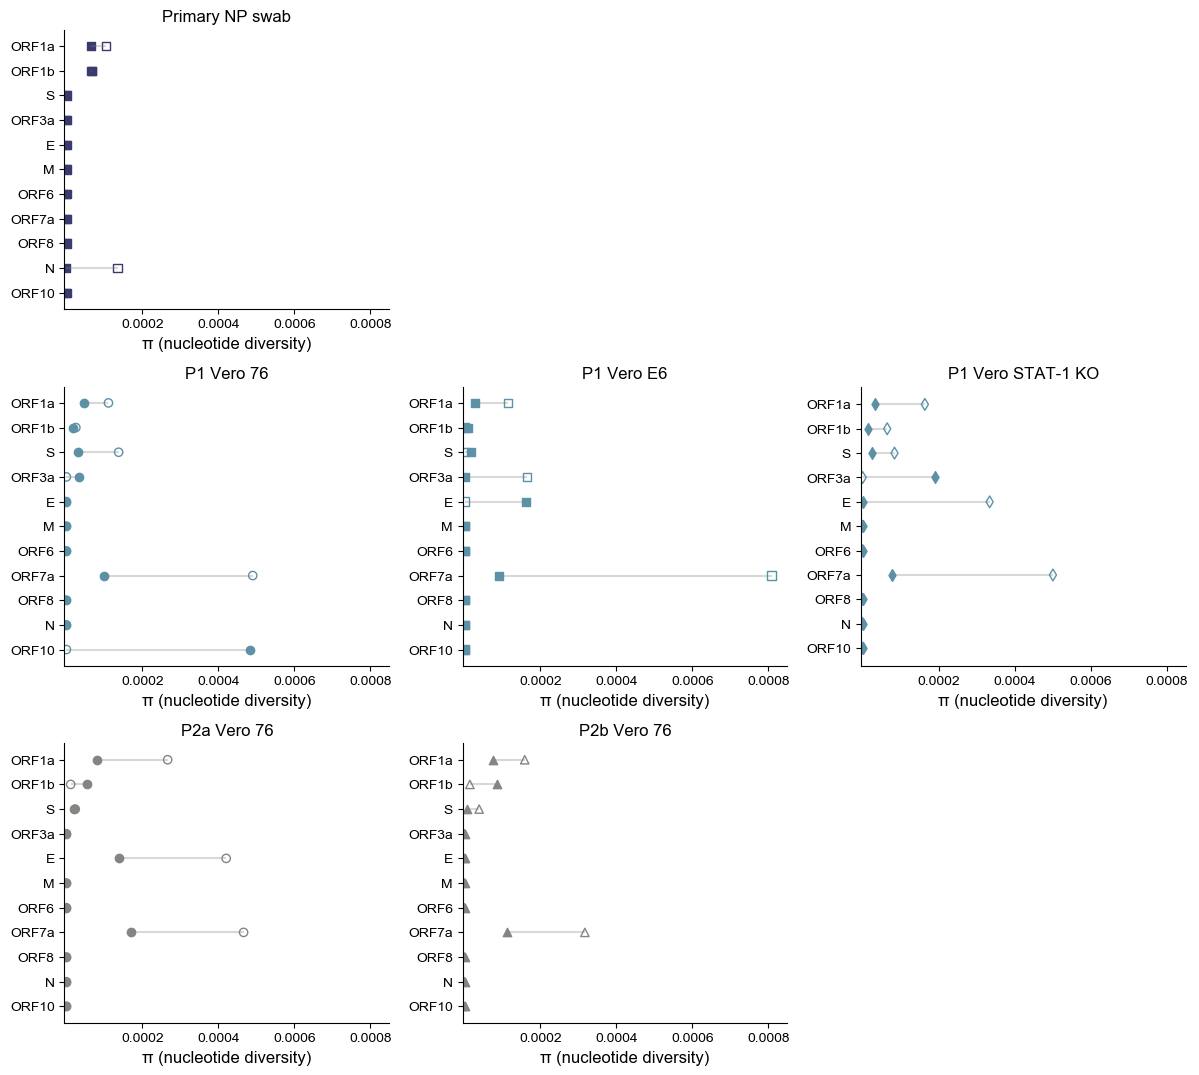

In [111]:
pd.options.mode.chained_assignment = None  # default='warn'

# generate a figure with sub-plots 
fig1 = plt.figure(figsize=(24,14), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(4,18)

ax1 = fig1.add_subplot(gs[0, 0:3]) #primary_NP_swab
ax4 = fig1.add_subplot(gs[1, 0:3]) #p1_vero76
ax5 = fig1.add_subplot(gs[1, 3:6]) #p1_veroE6
ax6 = fig1.add_subplot(gs[1, 6:9]) #p1_veroSTAT1KO
ax8 = fig1.add_subplot(gs[2, 0:3]) #p2a_vero76
ax9 = fig1.add_subplot(gs[2, 3:6]) #p2b_vero76

# get right of top and right frame of each subplot
axes = (ax1, ax4, ax5, ax6, ax8, ax9)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

# Make the plot

ax1.set_title('Primary NP swab', fontname='Arial', fontsize=12)
my_range1=range(1,len(primary_NP_swab.index)+1)
ax1.invert_yaxis()
ax1.hlines(y=my_range1, xmin=primary_NP_swab['piN'], xmax=primary_NP_swab['piS'], color='grey', alpha=0.3)
ax1.scatter(primary_NP_swab['piN'], my_range1, color='#3A3A6E', marker='s', label='value1')
ax1.scatter(primary_NP_swab['piS'], my_range1, color='#3A3A6E', facecolors='none', marker='s', label='value2')
ax1.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
ax1.set_xlim([-0.000005, 0.00085])
ax1.set_xticks([0.0002, 0.0004, 0.0006, 0.0008])
ax1.set_xlabel('π (nucleotide diversity)', fontname='Arial', fontsize=12)
ax1.set_yticklabels(['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10'])

ax4.set_title('P1 Vero 76', fontname='Arial', fontsize=12)
my_range4=range(1,len(p1_vero76.index)+1)
ax4.invert_yaxis()
ax4.hlines(y=my_range4, xmin=p1_vero76['piN'], xmax=p1_vero76['piS'], color='grey', alpha=0.3)
ax4.scatter(p1_vero76['piN'], my_range4, color='#5B92A8', marker='o', label='value1')
ax4.scatter(p1_vero76['piS'], my_range4, color='#5B92A8', facecolors='none', marker='o', label='value2')
ax4.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
ax4.set_xlim([-0.000005, 0.00085])
ax4.set_xticks([0.0002, 0.0004, 0.0006, 0.0008])
ax4.set_xlabel('π (nucleotide diversity)', fontname='Arial', fontsize=12)
ax4.set_yticklabels(['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10'])

ax5.set_title('P1 Vero E6', fontname='Arial', fontsize=12)
my_range5=range(1,len(p1_veroE6.index)+1)
ax5.invert_yaxis()
ax5.hlines(y=my_range5, xmin=p1_veroE6['piN'], xmax=p1_veroE6['piS'], color='grey', alpha=0.3)
ax5.scatter(p1_veroE6['piN'], my_range5, color='#5B92A8', marker='s', label='value1')
ax5.scatter(p1_veroE6['piS'], my_range5, color='#5B92A8', facecolors='none', marker='s', label='value2')
ax5.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
ax5.set_xlim([-0.000005, 0.00085])
ax5.set_xticks([0.0002, 0.0004, 0.0006, 0.0008])
ax5.set_xlabel('π (nucleotide diversity)', fontname='Arial', fontsize=12)
ax5.set_yticklabels(['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10'])

ax6.set_title('P1 Vero STAT-1 KO', fontname='Arial', fontsize=12)
my_range6=range(1,len(p1_veroSTAT1KO.index)+1)
ax6.invert_yaxis()
ax6.hlines(y=my_range6, xmin=p1_veroSTAT1KO['piN'], xmax=p1_veroSTAT1KO['piS'], color='grey', alpha=0.3)
ax6.scatter(p1_veroSTAT1KO['piN'], my_range6, color='#5B92A8', marker='d', label='value1')
ax6.scatter(p1_veroSTAT1KO['piS'], my_range6, color='#5B92A8', facecolors='none', marker='d', label='value2')
ax6.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
ax6.set_xlim([-0.000005, 0.00085])
ax6.set_xticks([0.0002, 0.0004, 0.0006, 0.0008])
ax6.set_xlabel('π (nucleotide diversity)', fontname='Arial', fontsize=12)
ax6.set_yticklabels(['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10'])

ax8.set_title('P2a Vero 76', fontname='Arial', fontsize=12)
my_range8=range(1,len(p2a_vero76.index)+1)
ax8.invert_yaxis()
ax8.hlines(y=my_range8, xmin=p2a_vero76['piN'], xmax=p2a_vero76['piS'], color='grey', alpha=0.3)
ax8.scatter(p2a_vero76['piN'], my_range8, color='#838681', marker='o', label='value1')
ax8.scatter(p2a_vero76['piS'], my_range8, color='#838681', facecolors='none', marker='o', label='value2')
ax8.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
ax8.set_xlim([-0.000005, 0.00085])
ax8.set_xticks([0.0002, 0.0004, 0.0006, 0.0008])
ax8.set_xlabel('π (nucleotide diversity)', fontname='Arial', fontsize=12)
ax8.set_yticklabels(['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10'])

ax9.set_title('P2b Vero 76', fontname='Arial', fontsize=12)
my_range9=range(1,len(p2b_vero76.index)+1)
ax9.invert_yaxis()
ax9.hlines(y=my_range9, xmin=p2b_vero76['piN'], xmax=p2b_vero76['piS'], color='grey', alpha=0.3)
ax9.scatter(p2b_vero76['piN'], my_range9, color='#838681', marker='^', label='value1')
ax9.scatter(p2b_vero76['piS'], my_range9, color='#838681', facecolors='none', marker='^', label='value2')
ax9.set_yticks([1,2,3,4,5,6,7,8,9,10,11])
ax9.set_xlim([-0.000005, 0.00085])
ax9.set_xticks([0.0002, 0.0004, 0.0006, 0.0008])
ax9.set_xlabel('π (nucleotide diversity)', fontname='Arial', fontsize=12)
ax9.set_yticklabels(['ORF1a', 'ORF1b', 'S', 'ORF3a', 'E', 'M', 'ORF6', 'ORF7a', 'ORF8', 'N', 'ORF10'])

# add a legend to this plot - use the same as the SNV 

# use tight_layout to optimize spacing of axes and titles within each subplot
fig1.tight_layout()
fig1.show()

# save this plot to the figures folder 
fig1.savefig("../../figures/π.pdf", bbox_inches='tight', dpi=300)

#